<a href="https://colab.research.google.com/github/tomoyok/Test-Fin-Tech-Case/blob/main/LLM_FADT_Colab_np20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **案例11 LLM-FADT（大模型增强文本选股）jupyter notebook实现**

本 notebook 包含完整实现：

数据准备 → BERT-FADT 基线 → LLM 多角度重构 → 先训练后合成 → 因子评估与回测

注：此处将安装单元调整为 **numpy==2.0.0** 方案（卸除冲突包），以适配当前的jupyter notebook环境，如有不同情况请动态调整。


In [ ]:
# ==============================
# 1) 安装依赖（Colab环境，numpy≈2.0方案）
# ==============================
# 如出现 IPython/Jedi 的提示，通常可忽略；若导入报错再按需安装兼容版本：
%pip -q install "jedi==0.18.1"

# 固定核心库版本：pandas 与 google-colab 兼容
%pip -q install "pandas==2.2.2" "numpy==2.0.0"

# 安装其余依赖，仅在需要时升级，尽量不触碰核心库
%pip -q install --upgrade-strategy only-if-needed transformers accelerate bitsandbytes peft xgboost lightgbm datasets scikit-learn faiss-cpu jieba tqdm sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 19.2 MB/s eta 0:00:00


In [ ]:
# ==============================
# 2) 导入与全局配置
# ==============================
import os, re, json, math, random, gc
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm.auto import tqdm

import torch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt

from transformers import (
    AutoTokenizer, AutoModel, AutoModelForCausalLM
)

# 随机种子
# 42是个magic number...
SEED = 42
random.seed(SEED);
np.random.seed(SEED);
torch.manual_seed(SEED)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# 备用LLM list
# ========== 可调参数 ==========
BASE_ENCODER_MODEL = "IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment"
LLM_CANDIDATES = [
    "Qwen/Qwen2.5-1.5B-Instruct",
    "Qwen/Qwen2-7B-Instruct",
    "Qwen/Qwen2.5-7B-Instruct",
]
LLM_SELECTED = None

HORIZON_DAYS = 21
REBAL_FREQ = "M"
TOP_N = 25
MAX_SEQ_LEN = 512
MAX_DOCS = None
BATCH_SIZE_ENC = 16
BATCH_SIZE_LLM = 4

# macro
COL_TS = "ts_code"
COL_DATE = "pub_date"
COL_TITLE = "title"
COL_CONTENT = "content"
COL_CLOSE = "close"
COL_MKT_DATE = "date"

pd.set_option("display.max_colwidth", 200)
print("Setting param done...")

Using device: cuda
Setting param done...


In [ ]:
# ==============================
# *) 数据上传（CSV / Tushare）
#   此处用mockdata体验
# ==============================
from google.colab import files
uploaded = files.upload()  # 选择 reports.csv 和 prices.csv 上传

import pandas as pd
reports = pd.read_csv("reports.csv")
prices = pd.read_csv("prices.csv")

print(reports.head())
print(prices.head())

Saving prices.csv to prices.csv
Saving reports.csv to reports.csv
  ts_code    pub_date       title                             content
0  AAA.SZ  2023-01-10  【行业点评】机会凸显       主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。
1  AAA.SZ  2023-01-17  【行业点评】机会凸显             产品迭代放缓，短期需求疲软，库存去化尚需时日。
2  AAA.SZ  2023-01-24  【行业点评】机会凸显       主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。
3  AAA.SZ  2023-01-31  【行业点评】机会凸显       主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。
4  AAA.SZ  2023-02-07  【行业点评】深度解读  公司布局 AI 业务，算力合作落地，边际改善显著；海外渠道拓展顺利。
  ts_code        date     close
0  AAA.SZ  2023-01-01  9.990901
1  AAA.SZ  2023-01-02  9.967772
2  AAA.SZ  2023-01-03  9.946499
3  AAA.SZ  2023-01-04  9.947593
4  AAA.SZ  2023-01-05  9.905971


In [ ]:
# ==============================
# 3) 数据准备（CSV / Tushare）
# ==============================
USE_TUSHARE = False

DATA_DIR = "/content"
REPORT_CSV = os.path.join(DATA_DIR, "reports.csv")
PRICE_CSV = os.path.join(DATA_DIR, "prices.csv")

# local csv
if not USE_TUSHARE:
    if not (os.path.exists(REPORT_CSV) and os.path.exists(PRICE_CSV)):
        # mock data
        print("未发现reports.csv/prices.csv，生成模拟数据。")
        rng = pd.date_range("2023-01-01", "2023-03-31", freq="D")
        mock_prices = []
        for code in ["AAA.SZ", "BBB.SH"]:
            price = 10.0 + np.cumsum(np.random.randn(len(rng))*0.05)
            mock_prices.append(pd.DataFrame({COL_TS: code, COL_MKT_DATE: rng.strftime("%Y-%m-%d"), COL_CLOSE: price}))
        prices = pd.concat(mock_prices, ignore_index=True)

        toy_reports = []
        texts = [
            "公司发布新品，预计销量超预期；签订百亿订单；管理层指引积极，盈利上修空间打开。",
            "主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。",
            "公司布局 AI 业务，算力合作落地，边际改善显著；海外渠道拓展顺利。",
            "产品迭代放缓，短期需求疲软，库存去化尚需时日。",
        ]
        for code in ["AAA.SZ", "BBB.SH"]:
            for d in pd.date_range("2023-01-10", "2023-03-15", freq="7D"):
                toy_reports.append({
                    COL_TS: code,
                    COL_DATE: d.strftime("%Y-%m-%d"),
                    COL_TITLE: "【行业点评】" + random.choice(["机会凸显", "风险提示", "深度解读"]),
                    COL_CONTENT: random.choice(texts)
                })
        reports = pd.DataFrame(toy_reports)
    else:
        reports = pd.read_csv(REPORT_CSV)
        prices = pd.read_csv(PRICE_CSV)
else:
    raise NotImplementedError("如需 Tushare，请自行实现数据拉取。")

print("Prices shape:", prices.shape)
print(prices.head(3))
print("Reports shape:", reports.shape)
print(reports.head(3))
reports[COL_DATE] = pd.to_datetime(reports[COL_DATE])
prices[COL_MKT_DATE] = pd.to_datetime(prices[COL_MKT_DATE])
if MAX_DOCS is not None and len(reports) > MAX_DOCS:
    reports = reports.sort_values(COL_DATE).head(MAX_DOCS).copy()

print("Prices shape:", prices.shape)
print(prices.head(3))
print("Reports shape:", reports.shape)
print(reports.head(3))

Prices shape: (180, 3)
  ts_code        date     close
0  AAA.SZ  2023-01-01  9.990901
1  AAA.SZ  2023-01-02  9.967772
2  AAA.SZ  2023-01-03  9.946499
Reports shape: (20, 4)
  ts_code    pub_date       title                        content
0  AAA.SZ  2023-01-10  【行业点评】机会凸显  主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。
1  AAA.SZ  2023-01-17  【行业点评】机会凸显        产品迭代放缓，短期需求疲软，库存去化尚需时日。
2  AAA.SZ  2023-01-24  【行业点评】机会凸显  主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。
Prices shape: (180, 3)
  ts_code       date     close
0  AAA.SZ 2023-01-01  9.990901
1  AAA.SZ 2023-01-02  9.967772
2  AAA.SZ 2023-01-03  9.946499
Reports shape: (20, 4)
  ts_code   pub_date       title                        content
0  AAA.SZ 2023-01-10  【行业点评】机会凸显  主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。
1  AAA.SZ 2023-01-17  【行业点评】机会凸显        产品迭代放缓，短期需求疲软，库存去化尚需时日。
2  AAA.SZ 2023-01-24  【行业点评】机会凸显  主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。


In [ ]:
# ==============================
# 4) 未来收益计算对齐（简化）
#   参考HORIZON_DAYS，默认21d
# ==============================
def compute_forward_return(df_price, horizon_days=21):
    # try resort in case of disorder
    df = df_price.sort_values([COL_TS, COL_MKT_DATE]).copy()
    # future close shifted by HORIZONDAY
    df["close_fwd"] = df.groupby(COL_TS)[COL_CLOSE].shift(-horizon_days)
    df["ret_fwd"] = df["close_fwd"] / df[COL_CLOSE] - 1.0
    print(df.head(10))
    return df
df_prices_feat = compute_forward_return(prices, HORIZON_DAYS)

# merge Reports and Prices by date&&ts_code
def map_report_to_return(reports, df_prices_with_ret):
    merged = pd.merge_asof(
        reports.sort_values(COL_DATE),
        df_prices_with_ret.sort_values(COL_MKT_DATE),
        left_on=COL_DATE, right_on=COL_MKT_DATE,
        by=COL_TS, direction="forward"
    )
    merged = merged[~merged["ret_fwd"].isna()].copy()
    return merged
df_all = map_report_to_return(reports, df_prices_feat)
print("Merged df_all shape:", df_all.shape)
df_all.head(5)


  ts_code       date     close  close_fwd   ret_fwd
0  AAA.SZ 2023-01-01  9.990901   9.811683 -0.017938
1  AAA.SZ 2023-01-02  9.967772   9.789864 -0.017848
2  AAA.SZ 2023-01-03  9.946499   9.785964 -0.016140
3  AAA.SZ 2023-01-04  9.947593   9.856174 -0.009190
4  AAA.SZ 2023-01-05  9.905971   9.819156 -0.008764
5  AAA.SZ 2023-01-06  9.942595   9.785854 -0.015765
6  AAA.SZ 2023-01-07  9.959742   9.839247 -0.012098
7  AAA.SZ 2023-01-08  9.941567   9.913348 -0.002838
8  AAA.SZ 2023-01-09  9.910131   9.832709 -0.007812
9  AAA.SZ 2023-01-10  9.874701   9.791298 -0.008446
Merged df_all shape: (18, 8)


,ts_code,pub_date,title,content,date,close,close_fwd,ret_fwd
0,AAA.SZ,2023-01-10,【行业点评】机会凸显,主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。,2023-01-10,9.874701,9.791298,-0.008446
1,BBB.SH,2023-01-10,【行业点评】深度解读,产品迭代放缓，短期需求疲软，库存去化尚需时日。,2023-01-10,10.271341,10.267560,-0.000368
2,AAA.SZ,2023-01-17,【行业点评】机会凸显,产品迭代放缓，短期需求疲软，库存去化尚需时日。,2023-01-17,9.780789,9.874354,0.009566
3,BBB.SH,2023-01-17,【行业点评】机会凸显,主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。,2023-01-17,10.188232,9.923399,-0.025994
4,AAA.SZ,2023-01-24,【行业点评】机会凸显,主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。,2023-01-24,9.785964,9.914578,0.013143


In [ ]:
# ==============================
# 5) 文本清洗与拼接。把title和content清洗并拼接
# ==============================
def clean_text(s):
    if not isinstance(s, str): return ""
    s = re.sub(r"\s+", " ", s)
    s = s.replace("\u3000", " ")
    return s.strip()

df_all["text"] = (df_all[COL_TITLE].fillna("").map(clean_text) + " \n " + df_all[COL_CONTENT].fillna("").map(clean_text))
print(df_all.shape)
print(df_all.head(10))

(18, 9)
  ts_code   pub_date       title                                  content  \
0  AAA.SZ 2023-01-10  【行业点评】机会凸显            主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。   
1  BBB.SH 2023-01-10  【行业点评】深度解读                  产品迭代放缓，短期需求疲软，库存去化尚需时日。   
2  AAA.SZ 2023-01-17  【行业点评】机会凸显                  产品迭代放缓，短期需求疲软，库存去化尚需时日。   
3  BBB.SH 2023-01-17  【行业点评】机会凸显            主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。   
4  AAA.SZ 2023-01-24  【行业点评】机会凸显            主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。   
5  BBB.SH 2023-01-24  【行业点评】机会凸显            主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。   
6  AAA.SZ 2023-01-31  【行业点评】机会凸显            主营面临竞争加剧，成本上升压力较大；行业政策存在不确定性。   
7  BBB.SH 2023-01-31  【行业点评】风险提示  公司发布新品，预计销量超预期；签订百亿订单；管理层指引积极，盈利上修空间打开。   
8  AAA.SZ 2023-02-07  【行业点评】深度解读       公司布局 AI 业务，算力合作落地，边际改善显著；海外渠道拓展顺利。   
9  BBB.SH 2023-02-07  【行业点评】深度解读                  产品迭代放缓，短期需求疲软，库存去化尚需时日。   

        date      close  close_fwd   ret_fwd  \
0 2023-01-10   9.874701   9.791298 -0.008446   
1 2023-01-10  10.271341  10.267560 -0.000368   


In [ ]:
# ==============================
# 6) BERT-FADT基线参考：文本编码。分词、编码
# ==============================
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel

pretrained_base_tokenizer = AutoTokenizer.from_pretrained(BASE_ENCODER_MODEL, trust_remote_code=True)
pretrained_base_encoder = AutoModel.from_pretrained(BASE_ENCODER_MODEL, trust_remote_code=True).to(device)
pretrained_base_encoder.eval()

def encode_texts(texts, max_len=512, batch_size=16):
    print('texts shape:', len(texts))
    vecs = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding (BERT baseline)"):
        batch_texts = texts[i:i+batch_size]
        inputs_real = pretrained_base_tokenizer(batch_texts, truncation=True, max_length=max_len, padding=True, return_tensors="pt").to(device)
        with torch.no_grad():
            out = pretrained_base_encoder(**inputs_real)
            if hasattr(out, "pooler_output") and out.pooler_output is not None:
                cls = out.pooler_output
            else:
                cls = out.last_hidden_state[:, 0]
            cls = F.normalize(cls, p=2, dim=1)
        vecs.append(cls.detach().cpu().numpy())
    return np.concatenate(vecs, axis=0)

X_base = encode_texts(df_all["text"].tolist(), max_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE_ENC)
print("Base embedding shape:", len(X_base))
print('X_base[0]:', len(X_base[0]))

texts shape: 18


Encoding (BERT baseline):   0%|          | 0/2 [00:00<?, ?it/s]

Base embedding shape: 18
X_base: 768


In [ ]:
# ==============================
# 7) 基线训练（XGBoost）。初步尝试Time Series利用XGB交叉训练预测
# ==============================
y = df_all["ret_fwd"].values.astype(np.float32)
tscv = TimeSeriesSplit(n_splits=5)
oof_pred_base = np.zeros(len(y), dtype=float)
for fold, (tr_idx, va_idx) in enumerate(tscv.split(X_base)):
    X_tr, y_tr = X_base[tr_idx], y[tr_idx]
    X_va, y_va = X_base[va_idx], y[va_idx]

    dtr = xgb.DMatrix(X_tr, label=y_tr)
    dva = xgb.DMatrix(X_va, label=y_va)

    params = dict(
        objective="reg:squarederror",
        max_depth=6,
        eta=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        nthread=0,
        reg_alpha=0.0,
        reg_lambda=1.0,
        min_child_weight=1.0,
        seed=SEED+fold,
    )
    model = xgb.train(params, dtr, num_boost_round=400,
                      evals=[(dtr,"train"),(dva,"valid")],
                      verbose_eval=False)
    oof_pred_base[va_idx] = model.predict(dva)

print("Baseline OOF R2:", r2_score(y, oof_pred_base))
df_all["pred_base"] = oof_pred_base

Baseline OOF R2: -0.08320433190573118


In [ ]:
# ==============================
# 8) LLM 多角度重构（Qwen Instruct → JSON）
#   input：一段中文的A股研报或点评摘要（非结构化文本）
#   ​output​​：一个结构化的JSON对象，包含了对该文本从多个量化投资角度（如市场情绪、催化剂、风险等）的解读和打分。
# ==============================
from transformers import BitsAndBytesConfig, AutoModelForCausalLM

def load_llm(candidates):
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.float16
    )
    last_err = None
    for name in candidates:
        try:
            tok = AutoTokenizer.from_pretrained(name, trust_remote_code=True)
            mdl = AutoModelForCausalLM.from_pretrained(
                name, device_map="auto", trust_remote_code=True,
                quantization_config=bnb_config
            )
            mdl.eval()
            # 有一个能用即可
            return name, tok, mdl
        except Exception as e:
            last_err = e
            print(f"加载失败：{name} -> {e}")
            gc.collect(); torch.cuda.empty_cache()
    raise RuntimeError(f"全部候选 LLM 加载失败：{last_err}")

# 加载 LLM
if LLM_SELECTED is None:
    LLM_SELECTED, tok_llm, llm = load_llm(LLM_CANDIDATES)
else:
    LLM_SELECTED, tok_llm, llm = load_llm([LLM_SELECTED])
print("Loaded LLM:", LLM_SELECTED)


'''
SYSTEM_PROMPT = (
    "你是一名买方量化研究助理。请阅读一段中文A股研报/点评摘要，"
    "从多个角度抽取结构化信息，并**只输出 JSON**。"
)
USER_TMPL = (
    "请基于以下文本，给出多角度重构：\n"
    "文本：\n{doc}\n\n"
    "请输出 JSON，字段包括：\n"
    "{"
    "\"title_rewrite\": string,  # 交易指向性的标题新解\n"
    "\"catalyst\": {\"has\": bool, \"type\": string, \"strength\": float},\n"
    "\"risks\": {\"has\": bool, \"strength\": float},\n"
    "\"sentiment\": float,    # -2~+2\n"
    "\"momentum_view\": float,# -2~+2\n"
    "\"uncertainty\": float   # 0~1\n"
    "}\n"
    "只输出一段 JSON，不要解释。"
)
'''
# ---------- 更严格的提示词（强制只输出纯 JSON） ----------
SYSTEM_PROMPT = (
    "你是一名买方量化研究助理。请阅读一段中文A股研报/点评摘要，"
    "从多个角度抽取结构化信息，并**只输出一段严格的JSON**。"
)
USER_TMPL = (
    "请基于以下文本，给出多角度重构：\n"
    "【文本】\n{doc}\n\n"
    "输出要求：\n"
    "1) 只输出一段严格JSON，不允许出现```代码块、解释性文字、注释。\n"
    "2) 使用标准 JSON 语法（true/false/null 小写；字符串用双引号）。\n"
    "3) 固定字段名与类型：\n"
    "{\n"
    "  \"title_rewrite\": string,\n"
    "  \"catalyst\": {\"has\": boolean, \"type\": string, \"strength\": number},\n"
    "  \"risks\": {\"has\": boolean, \"strength\": number},\n"
    "  \"sentiment\": number,\n"
    "  \"momentum_view\": number,\n"
    "  \"uncertainty\": number\n"
    "}\n"
    "现在请输出JSON："
)

# ---------- 更健壮的解析器 ----------
RE_CODEFENCE = re.compile(r"```(?:json)?\s*([\s\S]*?)\s*```", re.IGNORECASE)

def _strip_codefence(s: str) -> str:
    m = RE_CODEFENCE.search(s)
    return m.group(1) if m else s

def _json_fixes(s: str) -> str:
    # 常见非标准JSON修正：True/False/None、尾逗号
    s = s.replace("None", "null").replace("True", "true").replace("False", "false")
    s = re.sub(r",\s*}", "}", s)
    s = re.sub(r",\s*]", "]", s)
    return s

def safe_extract_json(txt: str, required_keys=None, max_len=5000):
    """
    从模型输出尽力提取一个最小且有效的 JSON 对象：
    - 去掉 ```json 代码块
    - 用“平衡花括号”策略从短到长尝试解析
    - 进行若干常见修复
    """
    if not isinstance(txt, str) or not txt.strip():
        return None
    body = _strip_codefence(txt.strip())[:max_len]
    opens = [i for i, ch in enumerate(body) if ch == "{"]
    if not opens or "}" not in body:
        return None

    N = len(body)
    for start in opens:
        depth = 0
        for pos in range(start, N):
            ch = body[pos]
            if ch == "{": depth += 1
            elif ch == "}":
                depth -= 1
                if depth == 0:
                    cand = _json_fixes(body[start:pos+1])
                    try:
                        obj = json.loads(cand)
                        if isinstance(obj, dict):
                            if required_keys and not all(k in obj for k in required_keys):
                                continue
                            return obj
                    except Exception:
                        pass
    return None

REPAIR_TMPL = (
    "以下是模型输出的文本，请你**只返回严格有效的JSON**，保持字段与数值含义：\n"
    "----\n{bad}\n----\n"
    "只输出JSON，不要任何解释。"
)
REQUIRED_KEYS = ["title_rewrite","catalyst","risks","sentiment","momentum_view","uncertainty"]

# ---------- 生成与纠错 ----------
def llm_multi_view(text_list, batch_size=1, max_new_tokens=192, doc_max_chars=1000):
    results = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        for t in batch:
            prompt = USER_TMPL.replace("{doc}", (t or "")[:doc_max_chars])
            messages = [
                {"role":"system", "content": SYSTEM_PROMPT},
                {"role":"user", "content": prompt}
            ]
            inps = tok_llm.apply_chat_template(messages, return_tensors="pt", add_generation_prompt=True).to(device)
            with torch.no_grad():
                out = llm.generate(inps, max_new_tokens=max_new_tokens, do_sample=False)
            raw = tok_llm.decode(out[0], skip_special_tokens=True)

            js = safe_extract_json(raw, required_keys=REQUIRED_KEYS)
            if js is None:
                # 一次“纠错”让模型把输出转成纯 JSON
                repair_msgs = [
                    {"role":"system", "content": "你是严格的JSON格式化器。"},
                    {"role":"user", "content": REPAIR_TMPL.replace("{bad}", raw[:1800])}
                ]
                rinps = tok_llm.apply_chat_template(repair_msgs, return_tensors="pt", add_generation_prompt=True).to(device)
                with torch.no_grad():
                    rout = llm.generate(rinps, max_new_tokens=256, do_sample=False)
                raw2 = tok_llm.decode(rout[0], skip_special_tokens=True)
                js = safe_extract_json(raw2, required_keys=REQUIRED_KEYS)

            results.append(js if isinstance(js, dict) else {})
            # 释放显存/内存，避免碎片化
            del inps, out
            if 'rinps' in locals(): del rinps, rout
            gc.collect()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
    return results

def ensure_defaults(js: dict) -> dict:
    """解析失败或缺字段时补默认值，保证后续流程不报错。"""
    js = js or {}
    js.setdefault("title_rewrite", "")
    js.setdefault("catalyst", {"has": False, "type": "", "strength": 0})
    js.setdefault("risks", {"has": False, "strength": 0})
    js.setdefault("sentiment", 0)
    js.setdefault("momentum_view", 0)
    js.setdefault("uncertainty", 0)
    return js

# ---------- 实际运行 ----------
df_all["mv_json"] = llm_multi_view(df_all["text"].tolist(), batch_size=1, max_new_tokens=192, doc_max_chars=1000)
df_all["mv_json"] = df_all["mv_json"].apply(ensure_defaults)
df_all["mv_json"].head(3).tolist()

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Loaded LLM: Qwen/Qwen2.5-1.5B-Instruct


The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature', 'top_p'

[{'title_rewrite': '',
  'catalyst': {'has': False, 'type': '', 'strength': 0},
  'risks': {'has': False, 'strength': 0},
  'sentiment': 0,
  'momentum_view': 0,
  'uncertainty': 0},
 {'title_rewrite': '',
  'catalyst': {'has': False, 'type': '', 'strength': 0},
  'risks': {'has': False, 'strength': 0},
  'sentiment': 0,
  'momentum_view': 0,
  'uncertainty': 0},
 {'title_rewrite': '',
  'catalyst': {'has': False, 'type': '', 'strength': 0},
  'risks': {'has': False, 'strength': 0},
  'sentiment': 0,
  'momentum_view': 0,
  'uncertainty': 0}]

In [ ]:
# ==============================
# 9) 多角度 JSON → 数值特征
# ==============================
from collections import defaultdict

def json_to_features(js):
    d = defaultdict(lambda: np.nan)
    if not isinstance(js, dict): return d

    title_new = js.get("title_rewrite", "") or ""
    d["title_new_len"] = len(title_new)

    cat = js.get("catalyst") or {}
    d["catalyst_has"] = float(bool(cat.get("has", False)))
    d["catalyst_strength"] = float(cat.get("strength", np.nan))
    cat_type = (cat.get("type") or "").strip()
    for key in ["政策", "订单", "新品", "并购", "产能", "算力", "海外", "其他"]:
        d[f"cat_{key}"] = 1.0 if key in cat_type else 0.0

    rsk = js.get("risks") or {}
    d["risk_has"] = float(bool(rsk.get("has", False)))
    d["risk_strength"] = float(rsk.get("strength", np.nan))

    d["sentiment"] = float(js.get("sentiment", np.nan))
    d["momentum_view"] = float(js.get("momentum_view", np.nan))
    d["uncertainty"] = float(js.get("uncertainty", np.nan))

    return d

feat_rows = [json_to_features(js) for js in df_all["mv_json"].tolist()]
df_mv = pd.DataFrame(feat_rows).fillna(0.0)
print("Multi-view feature shape:", df_mv.shape)
df_mv.head(5)

Multi-view feature shape: (18, 16)


,title_new_len,catalyst_has,catalyst_strength,cat_政策,cat_订单,cat_新品,cat_并购,cat_产能,cat_算力,cat_海外,cat_其他,risk_has,risk_strength,sentiment,momentum_view,uncertainty
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# ==============================
# 10) 先训练后合成：子模型 + 融合
# ==============================
ANGLE_CFG = {
    "catalyst": ["catalyst_has", "catalyst_strength"] + [c for c in df_mv.columns if c.startswith("cat_")],
    "risk":     ["risk_has", "risk_strength", "uncertainty"],
    "view":     ["sentiment", "momentum_view", "title_new_len"],
}

def train_oof_lgb(X, y, feature_names, n_splits=5, seed=42):
    Xv = X[feature_names].values.astype(np.float32)
    tscv = TimeSeriesSplit(n_splits=n_splits)
    oof = np.zeros(len(y), dtype=float)
    for k, (tr, va) in enumerate(tscv.split(Xv)):
        lgbm = lgb.LGBMRegressor(
            n_estimators=800, learning_rate=0.03, max_depth=-1,
            subsample=0.8, colsample_bytree=0.8, random_state=seed+k,
            objective="regression", n_jobs=-1
        )
        lgbm.fit(Xv[tr], y[tr], eval_set=[(Xv[va], y[va])], eval_metric="l2")
        oof[va] = lgbm.predict(Xv[va])
    return oof

y = df_all["ret_fwd"].values.astype(np.float32)
oof_parts = {name: train_oof_lgb(df_mv, y, cols, n_splits=5) for name, cols in ANGLE_CFG.items()}

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Z = np.vstack([oof_parts[k] for k in ANGLE_CFG.keys()]).T
Z_std = scaler.fit_transform(Z)

ridge = RidgeCV(alphas=np.logspace(-3, 2, 20), cv=5).fit(Z_std, y)
oof_fused = ridge.predict(Z_std)

print("Per-angle OOF R2:", {k: round(r2_score(y, v), 4) for k, v in oof_parts.items()})
print("Fused (Ridge) OOF R2:", round(r2_score(y, oof_fused), 4))

df_all["pred_llm_fadt"] = oof_fused


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 3, number of used features: 0
[LightGBM] [Info] Start training from score 0.000251
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/v

[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more 

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Per-angle OOF R2: {'catalyst': -0.1483, 'risk': -0.1483, 'view': -0.1483}
Fused (Ridge) OOF R2: 0.0


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26376 (\N{CJK UNIFIED IDEOGRAPH-6708}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


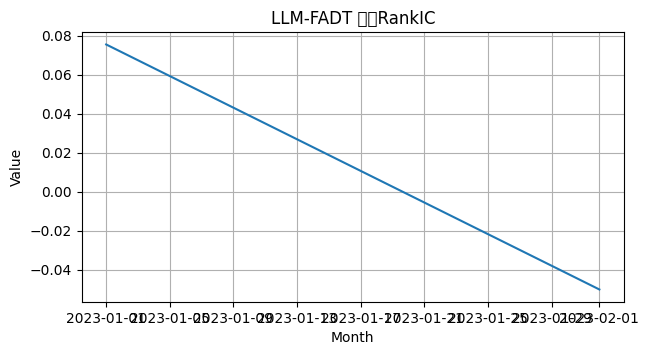

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


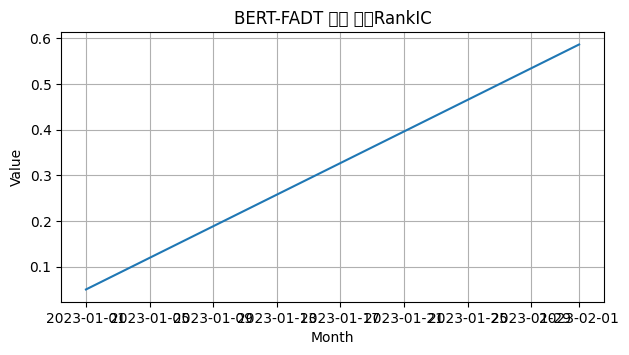

LLM-FADT RankIC 均值: 0.01276513858483478
BERT 基线 RankIC 均值: 0.31844974288483635


In [ ]:
# ==============================
# 11) 因子评估：RankIC、TopN
# ==============================
def month_key(dt: pd.Timestamp):
    return pd.Timestamp(year=dt.year, month=dt.month, day=1)

df_all["month"] = df_all[COL_DATE].apply(month_key)

def rank_ic_by_month(df, pred_col="pred_llm_fadt"):
    ics = []
    for (m), g in df.groupby("month"):
        if g[pred_col].nunique() < 3:
            continue
        ic = g[[pred_col, "ret_fwd"]].rank(pct=True).corr().iloc[0,1]
        ics.append({"month": m, "IC": ic})
    return pd.DataFrame(ics).sort_values("month")

ic_llm = rank_ic_by_month(df_all, "pred_llm_fadt")
ic_base = rank_ic_by_month(df_all, "pred_base")

import matplotlib.pyplot as plt

def plot_series(x, y, title):
    plt.figure(figsize=(7,3.5))
    plt.plot(x, y); plt.title(title); plt.xlabel("Month"); plt.ylabel("Value"); plt.grid(True); plt.show()

plot_series(ic_llm["month"], ic_llm["IC"], "LLM-FADT 月度RankIC")
plot_series(ic_base["month"], ic_base["IC"], "BERT-FADT 基线 月度RankIC")

print("LLM-FADT RankIC 均值:", ic_llm["IC"].mean() if len(ic_llm) else np.nan)
print("BERT 基线 RankIC 均值:", ic_base["IC"].mean() if len(ic_base) else np.nan)


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32452 (\N{CJK UNIFIED IDEOGRAPH-7EC4}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20928 (\N{CJK UNIFIED IDEOGRAPH-51C0}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 20540 (\N{CJK UNIFIED IDEOGRAPH-503C}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 65288 (\N{FULLWIDTH LEFT PARENTHESIS}) missing from font(s) DejaVu Sans.
  fig.canvas

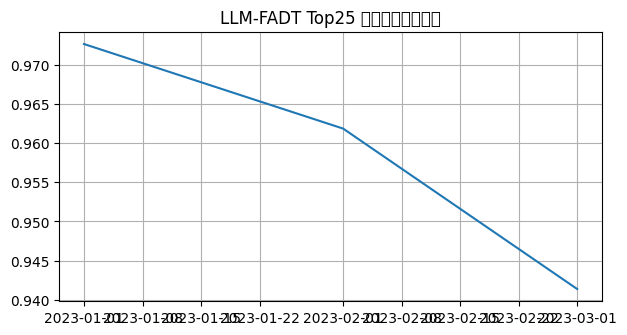

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 22522 (\N{CJK UNIFIED IDEOGRAPH-57FA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32447 (\N{CJK UNIFIED IDEOGRAPH-7EBF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


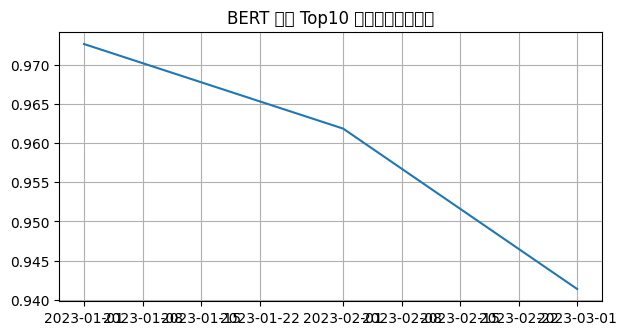

(       month       ret       nav
 0 2023-01-01 -0.027373  0.972627
 1 2023-02-01 -0.011089  0.961842
 2 2023-03-01 -0.021272  0.941381,
        month       ret       nav
 0 2023-01-01 -0.027373  0.972627
 1 2023-02-01 -0.011089  0.961842
 2 2023-03-01 -0.021272  0.941381)

In [ ]:
# ==============================
# 12) TopN 组合（简化）
# ==============================
def monthly_portfolio_return(df, score_col, top_n=25):
    last_per_month = df.sort_values(COL_DATE).groupby(["month", COL_TS]).tail(1).copy()
    rets = []
    for m, g in last_per_month.groupby("month"):
        top = g.sort_values(score_col, ascending=False).head(top_n)
        if len(top) == 0: continue
        ret = top["ret_fwd"].mean()
        rets.append({"month": m, "ret": ret})
    return pd.DataFrame(rets).sort_values("month")

ret_top25_llm = monthly_portfolio_return(df_all, "pred_llm_fadt", top_n=TOP_N)
ret_top10_baseline = monthly_portfolio_return(df_all, "pred_base", top_n=10)

def cum_return(df_ret):
    df = df_ret.copy()
    df["nav"] = (1.0 + df["ret"]).cumprod()
    return df

cum_llm = cum_return(ret_top25_llm)
cum_base = cum_return(ret_top10_baseline)

plt.figure(figsize=(7,3.5)); plt.plot(cum_llm["month"], cum_llm["nav"]); plt.title(f"LLM-FADT Top{TOP_N} 组合净值（简化）"); plt.grid(True); plt.show()
plt.figure(figsize=(7,3.5)); plt.plot(cum_base["month"], cum_base["nav"]); plt.title("BERT 基线 Top10 组合净值（简化）"); plt.grid(True); plt.show()

cum_llm.tail(3), cum_base.tail(3)
